In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 訓練集與測試集的資料增強與預處理
train_datagen = ImageDataGenerator(
    rescale=1./255,        # 標準化像素值到 [0, 1]
    rotation_range=20,     # 隨機旋轉圖片
    width_shift_range=0.2, # 水平位移
    height_shift_range=0.2,# 垂直位移
    shear_range=0.2,       # 剪切變換
    zoom_range=0.2,        # 縮放
    horizontal_flip=True,  # 水平翻轉
    fill_mode='nearest'    # 填充方式
)

test_datagen = ImageDataGenerator(rescale=1./255) # 測試集僅進行標準化

# 載入資料集
train_dataset = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' # 多類別分類 (這裡是2類)
)

test_dataset = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 4296 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# 載入 VGG16 預訓練模型 (不包含分類層)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 固定預訓練權重
for layer in base_model.layers:
    layer.trainable = False

# 添加自定義分類層
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') # 2類分類
])

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 模型訓練
history = model.fit(train_dataset, epochs=1, validation_data=test_dataset)
model.save('mask_classifier.h5')  # 儲存模型



 81/135 [=================>............] - ETA: 1:26 - loss: 0.8745 - accuracy: 0.8349

c:\Users\EE715\anaconda3\envs\hw5_env\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


135/135 [==============================] - 224s 2s/step - loss: 0.5970 - accuracy: 0.8738 - val_loss: 0.2217 - val_accuracy: 0.9189


In [20]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

# 載入模型
model = load_model('mask_classifier.h5')

# 設置類別名稱
class_names = {0: 'with_mask', 1: 'without_mask'}

def test_image(image_url, model, class_names):
    # 下載圖片
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image.resize((224, 224))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    # 預測結果
    predictions = model.predict(image)
    predicted_class = class_names[np.argmax(predictions)]
    print(f"Predicted Class: {predicted_class}")

# 測試圖片
image_url = input("請輸入圖片網址： ")
test_image(image_url, model, class_names)


1/1 [==============================] - 0s 138ms/step
Predicted Class: without_mask


1/1 [==============================] - 0s 146ms/step
Predicted Class: without_mask


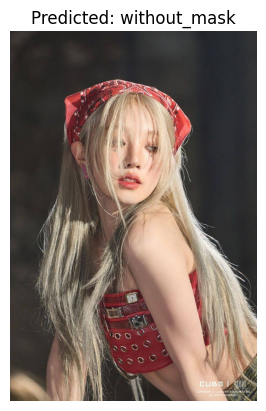

1/1 [==============================] - 0s 88ms/step
Predicted Class: without_mask


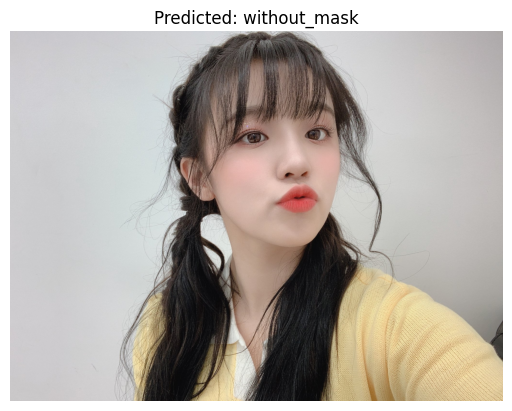

1/1 [==============================] - 0s 85ms/step
Predicted Class: with_mask


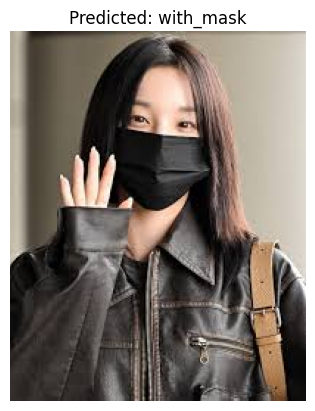

1/1 [==============================] - 0s 91ms/step
Predicted Class: with_mask


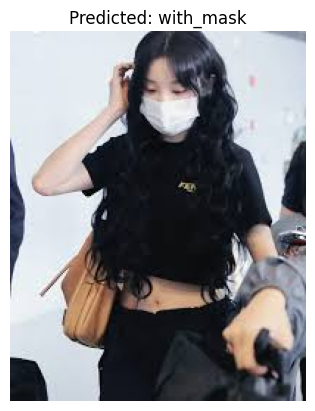

程式結束。


In [9]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 載入模型
model = load_model('mask_classifier.h5')

# 設置類別名稱
class_names = {0: 'with_mask', 1: 'without_mask'}

def test_image(image_url, model, class_names):
    try:
        # 下載圖片
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))
        image_resized = image.resize((224, 224))
        image_array = np.array(image_resized)
        image_array = np.expand_dims(image_array, axis=0)
        image_array = preprocess_input(image_array)
        
        # 預測結果
        predictions = model.predict(image_array)
        predicted_class = class_names[np.argmax(predictions)]
        
        # 打印結果
        print(f"Predicted Class: {predicted_class}")
        
        # 顯示圖片
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class}")
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# 重複執行
while True:
    image_url = input("請輸入圖片網址 (或輸入 'n' 退出)： ")
    if image_url.lower() == 'n':
        print("程式結束。")
        break
    test_image(image_url, model, class_names)
